<a href="https://colab.research.google.com/github/ngzhankang/Deep-Learning/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1
Submitted by : P1935727 Ng Zhan Kang<br>
Class of DIT/FT/2B/11


---
---

# 1.Setting Up Working Environment In Google Colab

### 1.1 Ensuring 0% Util

---

Ensure that our slot give by Google is not utilized yet.

In [179]:
# to ensure that the current gpu utilization is 0
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Gen RAM Free: 11.8 GB  | Proc size: 2.3 GB
GPU RAM Free: 11122MB | Used: 319MB | Util   3% | Total 11441MB


### 1.2. Forcing Utils To 0% To Get A Clean Cluster

---

Please do not use this step unless forced to.

In [180]:
# if utilization is > 0, run this code(keep running this cell and the above cell till the util number is 0%):
# NOTE THAT RUNNING THIS MIGHT KILL GPU SESSION AND RESULT IN DATA LOSS(NOT ADVICABLE TO KEEP ON REUSING)
# !kill -9 -1

---
---

# 2.Ensuring GPU Is Utilized In Environment

### 2.1. See the list of available devices

---

This entire section can be omitted if users are not utilizing GPU at all.

In [181]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16243103723088123572
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12546924262611067939
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 16220557173246074871
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11146783616
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11005237391605735317
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [182]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [183]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [184]:
!nvidia-smi

Mon Nov 16 15:29:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    63W / 149W |    319MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

---
---

# 3.About The MNIST Dataset (Background Information)

## 3.1. Background
- The MNIST database(Modified National Institute of Standards and Technology database) history came to existence by 
- The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.

## 3.2. Classic MNIST Dataset
- For this problem, create a CNN for image classification and evaluate the performance of the network
- Prepare the data and perform necessary feature engineering
- Create **_three models_** 
- Evaluate the models and pick the best candidate
- Form some conclusions

---
---

# 4.Data Importing

### 4.1. Load the libraries

---

Import the necessary libraries.

In [185]:
# Suppress Future Warnings
import warnings
warnings.filterwarnings('ignore')

In [186]:
# check versions of libraries we are going to use
%tensorflow_version 2.x
import os
import tensorflow
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import platform

message="        Versions        "
print("*"*len(message))
print(message)
print("*"*len(message))
print("Tensorflow version={}".format(tensorflow.__version__))
print("Keras version={}".format(tensorflow.keras.__version__))
print("Sklearn version={}".format(sklearn.__version__))
print("Numpy version={}".format(np.__version__))
print("Pandas version={}".format(pd.__version__))
print("Seaborn version={}".format(sns.__version__))
print("Matplotlib version={}".format(matplotlib.__version__))
print("Python version={}".format(platform.python_version()))

************************
        Versions        
************************
Tensorflow version=2.3.0
Keras version=2.4.0
Sklearn version=0.22.2.post1
Numpy version=1.18.5
Pandas version=1.1.4
Seaborn version=0.11.0
Matplotlib version=3.2.2
Python version=3.6.9


In [187]:
# start importing necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, AveragePooling2D, Activation, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop, Adam

from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, History
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import losses
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools

%matplotlib inline

In [188]:
# fix random seed for reproducibility
np.random.seed(5)

In [189]:
# get the dataset from keras library in tensorflow 2.0
mnist = tf.keras.datasets.mnist

# unpack the dataset to the respective x_train, y_train, x_test and y_test
(x_train, y_train), (x_test, y_test) = mnist.load_data()

<div class="alert alert-block alert-info">
    <b>Analysis Summary:</b> MNIST Dataset includes handwritten digits from 0 to 9, and dimensions are 28 by 28 pixels. Each pixels is 8 bits, so its value ranges from to 0 to 255.<p>
</div>

### 4.2. Verify the dataset

---

Verify the credibility of the dataset first by plotting the 1st 25 images from the training set and display the class name below each image.

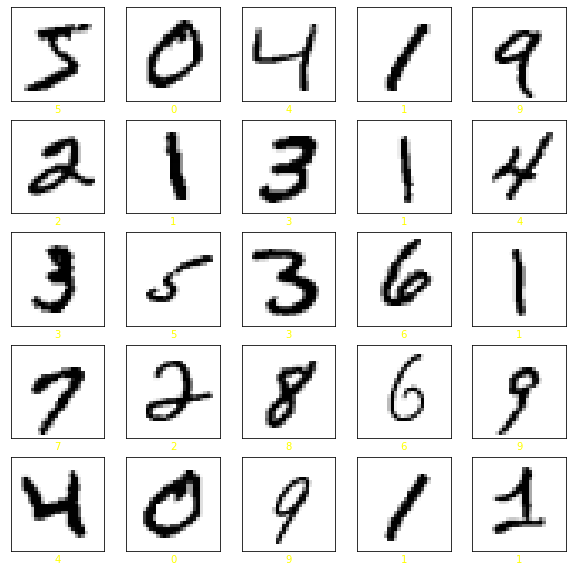

In [190]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i], color="yellow")
plt.show()

<div class="alert alert-block alert-info">
    <b>Analysis Summary:</b> It seems that the labels matches all the images, which is good! Now let's carry on to get a better insight of the datatset we are going to deal with.<p>
</div>

---
---

# 5.Exploratory Data Analysis

### 5.1. Basic Data Exploration

---

Take a peek look at what is inside the `x_train` and the `x_test`.

In [191]:
# take a look at the x_train set first
print(x_train.shape)
print(y_train.shape)

(60000, 28, 28)
(60000,)


In [192]:
# take a look at the x_test set
print(x_test.shape)
print(y_test.shape)

(10000, 28, 28)
(10000,)


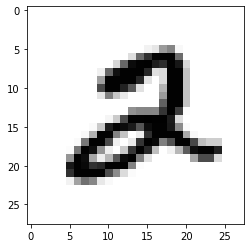

In [193]:
# grab a random picture to take a look
plt.imshow(x_train[5], cmap=plt.cm.binary)
plt.show()

In [194]:
# get the distinct lables that are found in the entire thing
print('Training set unique labels:',np.unique(y_train))
print('Test set unique labels:',np.unique(y_test))

Training set unique labels: [0 1 2 3 4 5 6 7 8 9]
Test set unique labels: [0 1 2 3 4 5 6 7 8 9]


In [195]:
# get the count of the values from 0 to 9
unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   0 5923]
 [   1 6742]
 [   2 5958]
 [   3 6131]
 [   4 5842]
 [   5 5421]
 [   6 5918]
 [   7 6265]
 [   8 5851]
 [   9 5949]]


Text(0.5, 1.0, 'Pixel Value Distribution')

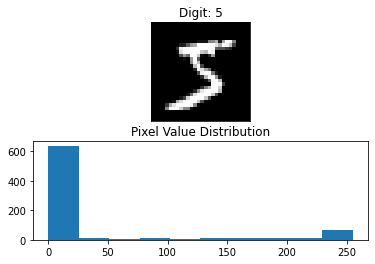

In [196]:
# get the distribution of our pixel values
fig = plt.figure()
plt.subplot(2,1,1)
plt.imshow(x_train[0], cmap='gray', interpolation='none')
plt.title("Digit: {}".format(y_train[0]))
plt.xticks([])
plt.yticks([])

plt.subplot(2,1,2)
plt.hist(x_train[0].reshape(784))
plt.title("Pixel Value Distribution")

<div class="alert alert-block alert-info">
    <b>Analysis Summary:</b> From what we can see, the pixel values ranges from 0 to 255, with the majority close to 0, and those close to 255 respresenting the digit.<p>
</div>

---
---

# 6.Feature Engineering

### 6.1. Changing Dimension To Match Keras Expectation

---

Reshape `x_train` and `x_test` to 4 dimensional array for the convolutional layer later on.

In [197]:
# flatten 28*28 pixel images to 784 pixels for each image(from a 2D array to a 1D array)
num_pixels = x_train.shape[1] * x_train.shape[2]
X_train = x_train.reshape(x_train.shape[0], num_pixels).astype('float32')
X_test = x_test.reshape(x_test.shape[0], num_pixels).astype('float32')

# see the changes
print('New X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

New X_train shape: (60000, 784)
60000 train samples
10000 test samples


### 6.2. Normalize Training Data

---

Normalize the entire training dataset so that there is not much variation.

In [198]:
# attempt to normalize the entire dataset first from 0-255 to 0-1
X_train /= 255
X_test /= 255

# see the shape of x_train and x_test first
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 784)
X_test shape: (10000, 784)
60000 train samples
10000 test samples


### 6.3. Convert To Categorical Data

---

Convert the labels to categorical data as we do not want the model to think 9 has a higher priority than 0.

In [199]:
# use to_categorical to convert the training and testing dataset labels
num_classes = 10 # number of classes (numbers 0 to 9)

Y_train = tf.keras.utils.to_categorical(y_train, num_classes)
Y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# now lets check again the training and test dataset labels
print('Y_train:', Y_train[0])
print('Y_test:', Y_test[0])

Y_train: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Y_test: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


### 6.4. Transforming to 2D array

---

We will change the numpy array to a 2D array so that we can feed inside our CNN models.

In [200]:
# reshape x_train and x_test to (n_images, x_shape, y_shape, channels)
# we are going to make chanels be 1 as we are not dealing with rgb images.
X_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
X_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# examine the shape before we feed it in
print('New X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

New X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


---
---

# 7.Models

### 7.1. Baseline CNN Model

---

First, we will setup a baseline model using a simple CNN architecture.

In [124]:
# create model and give it a name
model = Sequential(name="sequential_baseline_model")

# Layer 1 Conv2D
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))

# Layer 2 Pooling Layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 3 Flatten Layer
model.add(Flatten())

# Layer 4 Fully Connected Layer (Hidden Layer)
model.add(Dense(100, kernel_initializer='he_uniform', activation='relu'))

# Output layer
model.add(Dense(num_classes, activation='softmax'))

# model summary
model.summary()

Model: "sequential_baseline_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               540900    
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1010      
Total params: 542,230
Trainable params: 542,230
Non-trainable params: 0
_________________________________________________________________


In [125]:
# implement a learning rate schedule in keras
learning_rate = 0.001
beta_1 = 0.9
beta_2 = 0.999
epsilon = 1e-08

adam = Adam(lr=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)

In [126]:
# time to optimise the empty baseline model(an empty shell basically) and fit it with our training dataset
# passing params into the newly created model and compile it
model.compile(optimizer=adam,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

# train the model
history = model.fit(X_train, Y_train, validation_split=0.2, epochs=15, batch_size=32, verbose=1)

Epoch 1/15
1500/1500 [==============================] - 8s 5ms/step - loss: 0.6551 - accuracy: 0.9194 - val_loss: 0.1412 - val_accuracy: 0.9639
Epoch 2/15
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0947 - accuracy: 0.9725 - val_loss: 0.1072 - val_accuracy: 0.9697
Epoch 3/15
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0645 - accuracy: 0.9793 - val_loss: 0.1124 - val_accuracy: 0.9736
Epoch 4/15
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0502 - accuracy: 0.9842 - val_loss: 0.0873 - val_accuracy: 0.9791
Epoch 5/15
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0431 - accuracy: 0.9866 - val_loss: 0.1089 - val_accuracy: 0.9759
Epoch 6/15
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0354 - accuracy: 0.9891 - val_loss: 0.1013 - val_accuracy: 0.9759
Epoch 7/15
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0302 - accuracy: 0.9906 - val_loss: 0.1223 - val_accuracy:

In [127]:
#print the available history keys for use
print(history.history.keys()) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


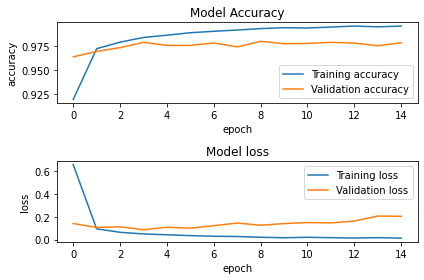

In [128]:
# plotting the accuracy and loss graphs
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='best')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training loss', 'Validation loss'], loc='best')

plt.tight_layout()

### 7.2. LeNet-5 CNN Model

---

Next, we will setup a CNN Model based on the LeNet-5 architecture.

<div class="alert alert-block alert-info">
    <b>Analysis Summary:</b> We  understand that there are a few main reasons for overfitting in Neural Networks. They are mainly due to the network size, lack of weight regularization and lack of dropouts. In order to reduce (or to  prevent this from happenening), we will implement these 3 main points. Here we will implement the fundemental LeNet-5 Architecture to test out how precise it is.<p>
</div>

In [201]:
# create model and give it a name
model = Sequential(name="lenet5_cnn_model_sequential")

# Layer 1 Conv2D
model.add(Conv2D(filters=6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(28, 28, 1), padding='same'))
# Layer 2 Pooling Layer
model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))

# Layer 3 Conv2D
model.add(Conv2D(filters=16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
# Layer 4 Pooling Layer
model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))

# Layer 5 Flatten
model.add(Flatten())

# Layer 6 Fully Connected Layer (Hidden Layer)
model.add(Dense(units=120, activation='tanh'))

# Layer 7 Fully Connected Layer (Hidden Layer)
model.add(Dense(units=84, activation='tanh'))

# Output layer
model.add(Dense(units=num_classes, activation='softmax'))

# get model summary
model.summary()

Model: "lenet5_cnn_model_sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d_2 (Average (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_3 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 120)               48120     
_________________________________________________________________
dense_12 (Dense)             (None, 84)

In [202]:
# time to optimise the empty CNN model(an empty shell basically) and fit it with our training dataset
# passing params into the newly created model and compile it
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

# train the model
history = model.fit(X_train,Y_train, validation_split=0.2, epochs=15, verbose=1)

Epoch 1/15
1500/1500 [==============================] - 8s 5ms/step - loss: 0.1713 - accuracy: 0.9486 - val_loss: 0.0809 - val_accuracy: 0.9753
Epoch 2/15
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0715 - accuracy: 0.9772 - val_loss: 0.0674 - val_accuracy: 0.9794
Epoch 3/15
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0520 - accuracy: 0.9831 - val_loss: 0.0583 - val_accuracy: 0.9818
Epoch 4/15
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0428 - accuracy: 0.9862 - val_loss: 0.0670 - val_accuracy: 0.9798
Epoch 5/15
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0355 - accuracy: 0.9881 - val_loss: 0.0488 - val_accuracy: 0.9857
Epoch 6/15
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0325 - accuracy: 0.9898 - val_loss: 0.0468 - val_accuracy: 0.9862
Epoch 7/15
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0262 - accuracy: 0.9914 - val_loss: 0.0540 - val_accuracy:

In [203]:
#print the available history keys for use
print(history.history.keys()) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


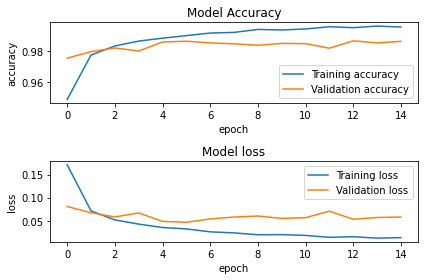

In [204]:
# plotting the accuracy and loss graphs
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='best')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training loss', 'Validation loss'], loc='best')

plt.tight_layout()

### 7.3. CNN Hyper-Parameter Tuned Model

---

Next, we will setup a CNN Model that has undergone hyper-parameter tuning.

<div class="alert alert-block alert-info">
    <b>Analysis Summary:</b> From above, we understand that there are a few main reasons for overfitting in Neural Networks. They are mainly due to the network size, lack of weight regularization and lack of dropouts. In order to reduce (or to  prevent this from happenening), we will implement these 3 main points. Currently, we will implement one of the successfull Neural Network Architecture called the LeNet-5 architecture. But for here we will use the CNN-ELM-DL4J Model, which mainly comprises the following layers: an input layer, a convolutional layer, a pooling layer, a fully connected layer, a SoftMax layer, and a ELM layer.<p>
</div>

In [82]:
# Instantiate a Sequential model
model = Sequential(name="cnn_model_hyperParamTuned_sequential_LeNet")

# 1st Convolutional Layer(we will use elu instead of relu)
model.add(Conv2D(filters=6, kernel_size=(5, 5), input_shape=(28, 28, 1), strides=(1, 1), activation='elu', padding='same'))
# Batch Normalization
model.add(BatchNormalization())
# Max Pooling
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

# 2nd Convolutional Layer
model.add(Conv2D(filters=16, kernel_size=(5, 5), strides=(1, 1), activation='elu', padding='valid'))
# Batch Normalization
model.add(BatchNormalization())
# Max Pooling
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

# # 3rd Convolutional Layer
# model.add(Conv2D(filters=32, strides=(1, 1), activation='relu'))
# # Batch Normalization
# model.add(BatchNormalization())

# Flatten layer
model.add(Flatten())

# 1st Fully Connected Layer
model.add(Dense(120, activation='elu'))
# Add Dropout to prevent overfitting
# model.add(Dropout(0.3))

# 2nd Fully Connected Layer
model.add(Dense(84, activation='elu'))

# Output Layer
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "cnn_model_hyperParamTuned_sequential_LeNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 6)         24        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
batch_normalization_3 (Batch (None, 10, 10, 16)        64        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)     

In [84]:
# passing params into the newly created model and compile it
model.compile(optimizer='adam',
          loss='categorical_crossentropy',
          metrics=['accuracy'])
  
# we shall do some ImageDataGenerator here to augment the input data, which can help over-fitting
train_gen = ImageDataGenerator(
    rotation_range=10,
    # height_shift_range=0.08,
    shear_range=0.3,
    # brightness_range=[0.6, 1.4],
    zoom_range=0.08
)
test_gen =  ImageDataGenerator()

In [85]:
# declare out batch size to be used here
BATCH_SIZE = 64

# generator to flow input images and labels into the model
train_generator = train_gen.flow(x_train, y_train, batch_size=BATCH_SIZE)
test_generator = test_gen.flow(x_test, y_test, batch_size=BATCH_SIZE)

In [86]:
# train the model (we use model.fit since model.fit_generator has been depreciated)
history = model.fit(
    train_generator,
    steps_per_epoch=60000//BATCH_SIZE,
    epochs=5,
    validation_data=test_generator,
    validation_steps=10000//BATCH_SIZE,
    callbacks=[EarlyStopping(monitor='loss', patience=1)]  
)

Epoch 1/5
937/937 [==============================] - 20s 22ms/step - loss: 0.1627 - accuracy: 0.9490 - val_loss: 0.0573 - val_accuracy: 0.9807
Epoch 2/5
937/937 [==============================] - 21s 22ms/step - loss: 0.0655 - accuracy: 0.9795 - val_loss: 0.0410 - val_accuracy: 0.9857
Epoch 3/5
937/937 [==============================] - 21s 22ms/step - loss: 0.0466 - accuracy: 0.9853 - val_loss: 0.0425 - val_accuracy: 0.9862
Epoch 4/5
937/937 [==============================] - 20s 22ms/step - loss: 0.0403 - accuracy: 0.9872 - val_loss: 0.0398 - val_accuracy: 0.9877
Epoch 5/5
937/937 [==============================] - 20s 22ms/step - loss: 0.0351 - accuracy: 0.9890 - val_loss: 0.0520 - val_accuracy: 0.9839


In [87]:
#print the available history keys for use
print(history.history.keys()) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


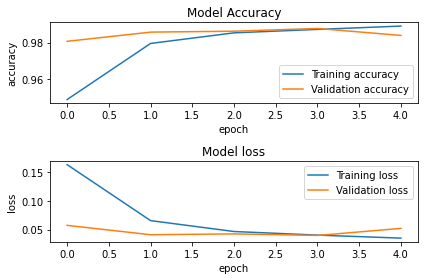

In [88]:
# plotting the accuracy and loss graphs
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='best')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training loss', 'Validation loss'], loc='best')

plt.tight_layout()

---
---

# 8.Test Accuracy, Loss And Results

### 8.1. Baseline Model Result

---

Get the result for the baseline model.

In [129]:
# now we shall evaluate the model and see the accuracy
loss, accuracy = model.evaluate(X_test,Y_test)
print("Test loss:", loss)
print("Test accuracy:", accuracy)
print("Baseline Model Accuracy: %.2f%%" % (accuracy*100))
print("Baseline Model Error: %.2f%%" % (100-accuracy*100))

313/313 [==============================] - 1s 4ms/step - loss: 0.2127 - accuracy: 0.9770
Test loss: 0.21265873312950134
Test accuracy: 0.9769999980926514
Baseline Model Accuracy: 97.70%
Baseline Model Error: 2.30%


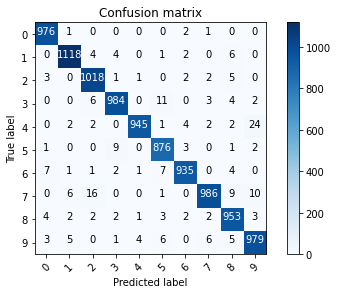

In [130]:
# plot our confusion matrix here to see how many labels got misplaced
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 


9770  classified correctly
230  classified incorrectly


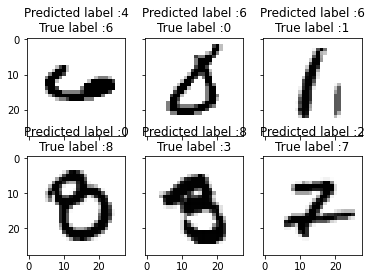

In [131]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_test[errors]

# see which we predicted correctly and which not
correct_indices = np.nonzero(Y_pred_classes == y_test)[0]
incorrect_indices = np.nonzero(Y_pred_classes != y_test)[0]
print()
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)), cmap=plt.cm.binary)
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

### 8.2. CNN Model Result

---

Get the result for the CNN model.

In [205]:
# now we shall evaluate the model and see the accuracy
loss, accuracy = model.evaluate(X_test,Y_test)
print("Test loss:", loss)
print("Test accuracy:", accuracy)
print("CNN Model Accuracy: %.2f%%" % (accuracy*100))
print("CNN Model Error: %.2f%%" % (100-accuracy*100))

313/313 [==============================] - 1s 4ms/step - loss: 0.0508 - accuracy: 0.9868
Test loss: 0.05080300197005272
Test accuracy: 0.9868000149726868
CNN Model Accuracy: 98.68%
CNN Model Error: 1.32%


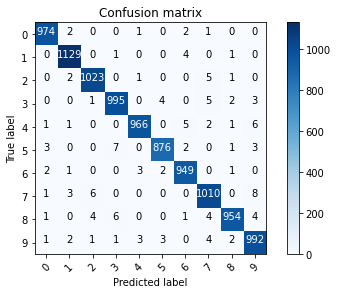

In [206]:
# plot our confusion matrix here to see how many labels got misplaced
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 


9868  classified correctly
132  classified incorrectly


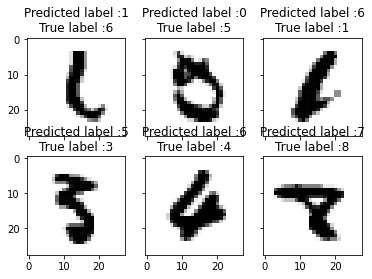

In [207]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_test[errors]

# see which we predicted correctly and which not
correct_indices = np.nonzero(Y_pred_classes == y_test)[0]
incorrect_indices = np.nonzero(Y_pred_classes != y_test)[0]
print()
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)), cmap=plt.cm.binary)
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

### 8.3. CNN Hyper-Parameter Tuned Model Result

---

Get the result for the CNN model that has undergone hyper parameter tuning.

In [89]:
# now we shall evaluate the model and see the accuracy
loss, accuracy = model.evaluate(x_test,y_test)
print("Test loss:", loss)
print("Test accuracy:", accuracy)
print("CNN Hyper-Parameter Tuned Model Accuracy: %.2f%%" % (accuracy*100))
print("CNN Hyper-Parameter Tuned Model Error: %.2f%%" % (100-accuracy*100))

313/313 [==============================] - 1s 4ms/step - loss: 0.0519 - accuracy: 0.9839
Test loss: 0.051930345594882965
Test accuracy: 0.9839000105857849
CNN Hyper-Parameter Tuned Model Accuracy: 98.39%
CNN Hyper-Parameter Tuned Model Error: 1.61%


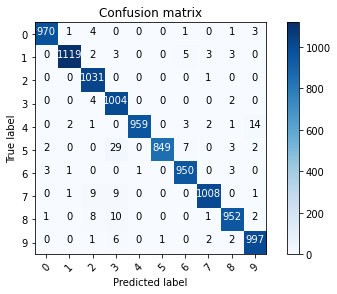

In [90]:
# plot our confusion matrix here to see how many labels got misplaced
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 


1047  classified correctly
98953  classified incorrectly


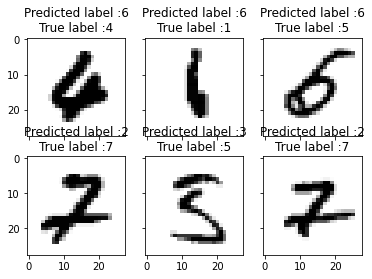

In [91]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = x_test[errors]

# see which we predicted correctly and which not
correct_indices = np.nonzero(Y_pred == y_test)[0]
incorrect_indices = np.nonzero(Y_pred != y_test)[0]
print()
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)), cmap=plt.cm.binary)
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

---
---

# 9.References

## Using Google Colab More Efficiently
- [Getting the Most Out of Your Google Colab (Tutorial)](https://medium.com/@oribarel/getting-the-most-out-of-your-google-colab-2b0585f82403)
- [Using Google Colab with GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)

## Background Research

## Selecting CNN Architecture
- [Top 10 CNN Architecture](https://towardsdatascience.com/illustrated-10-cnn-architectures-95d78ace614d#676b)
- [AlexNet: The Architecture that Challenged CNNs](https://towardsdatascience.com/alexnet-the-architecture-that-challenged-cnns-e406d5297951)
- [How to choose CNN Architecture MNIST](https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist#What-is-the-best-CNN-architecture-for-MNIST?)

## Some Tutorials on how to build a CNN Model
- [Building a Custom Convolutional Neural Network in Keras](https://medium.com/@ODSC/building-a-custom-convolutional-neural-network-in-keras-48171163aa7f)
- [The Most Intuitive and Easiest Guide for Convolutional Neural Network](https://towardsdatascience.com/the-most-intuitive-and-easiest-guide-for-convolutional-neural-network-3607be47480)
- [MNIST with Keras for Beginners(.99457)](https://www.kaggle.com/adityaecdrid/mnist-with-keras-for-beginners-99457)
- [Introduction to CNN Keras - Acc 0.997 (top 8%)](https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6)
- [Image Classification in 10 Minutes with MNIST Dataset](https://towardsdatascience.com/image-classification-in-10-minutes-with-mnist-dataset-54c35b77a38d)
- [How to Develop a CNN for MNIST Handwritten Digit Classification](https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/#:~:text=The%20MNIST%20dataset%20is%20an,digits%20between%200%20and%209.)
- [MNIST Handwritten Digit Recognition in Keras](https://nextjournal.com/gkoehler/digit-recognition-with-keras)

## Feature Engineering
- [Why Change Data Dimension Before Feeding Into Keras?](https://stackoverflow.com/a/62991238/12347869)
- [Properly Setting the Random Seed in ML Experiments. Not as Simple as You Might Imagine](https://medium.com/@ODSC/properly-setting-the-random-seed-in-ml-experiments-not-as-simple-as-you-might-imagine-219969c84752)
- [How to get reproducible results in keras](https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras)
- [How can I obtain reproducible results using Keras during development?](https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development)

## Building Layers
- [What is the default weight initializer in Keras?](https://stackoverflow.com/questions/54011173/what-is-the-default-weight-initializer-in-keras)
- [A Gentle Introduction to Pooling Layers for Convolutional Neural Networks](https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/)
- [Using the Keras Flatten Operation in CNN Models with Code Examples](https://missinglink.ai/guides/keras/using-keras-flatten-operation-cnn-models-code-examples/)
- [Dropout Neural Network Layer In Keras Explained](https://towardsdatascience.com/machine-learning-part-20-dropout-keras-layers-explained-8c9f6dc4c9ab)
- [Changing shape of MNIST for tensorflow CNN](https://stackoverflow.com/questions/50549859/changing-shape-of-mnist-for-tensorflow-cnn)

## Model Evaluation 
- [Sparse_categorical_crossentropy vs categorical_crossentropy (keras, accuracy)](https://datascience.stackexchange.com/questions/41921/sparse-categorical-crossentropy-vs-categorical-crossentropy-keras-accuracy)

## Hyper Parameter Tuning With Keras Tuner
- [Hyperparameter tuning with Keras Tuner](https://blog.tensorflow.org/2020/01/hyperparameter-tuning-with-keras-tuner.html)
- [Why is random search better than grid search for machine learning?](https://analyticsindiamag.com/why-is-random-search-better-than-grid-search-for-machine-learning/#:~:text=Random%20search%20is%20a%20technique,to%20yield%20better%20results%20comparatively.)
- [Hands on hyperparameter tuning with Keras Tuner](https://www.sicara.ai/blog/hyperparameter-tuning-keras-tuner)
- [Keras Tuner Docs](https://keras-team.github.io/keras-tuner/)
- [How do you decide the parameters of a Convolutional Neural Network for image classification?](https://stackoverflow.com/questions/24509921/how-do-you-decide-the-parameters-of-a-convolutional-neural-network-for-image-cla#:~:text=The%20Number%20of%20convolutional%20layers,you%20need%20to%20decide%20whether)
